In [2]:
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
import sys
import os

# Adiciona o diretório 'src' ao path do sistema para que possamos importar nosso módulo
sys.path.append(os.path.abspath(os.path.join('..')))
from src.data_loader import SiameseDataset

# Define os caminhos para as pastas de dados
DATA_DIR = '../data/dataset/'
T1_DIR = os.path.join(DATA_DIR, 't1')
T2_DIR = os.path.join(DATA_DIR, 't2')
MASK_DIR = os.path.join(DATA_DIR, 'mask')

In [3]:
# Cria uma instância do nosso dataset, apontando para as pastas corretas
burn_dataset = SiameseDataset(t1_dir=T1_DIR, t2_dir=T2_DIR, mask_dir=MASK_DIR)

# Cria o DataLoader para iterar sobre os dados em lotes
data_loader = DataLoader(burn_dataset, batch_size=4, shuffle=True)

print(f"Dataset carregado com sucesso! Encontradas {len(burn_dataset)} amostras.")

Dataset carregado com sucesso! Encontradas 945 amostras.


Dimensões do tensor T1 (Bandas, Altura, Largura): torch.Size([4, 128, 128])
Dimensões do tensor T2 (Bandas, Altura, Largura): torch.Size([4, 128, 128])
Dimensões da Máscara (Canais, Altura, Largura): torch.Size([1, 128, 128])


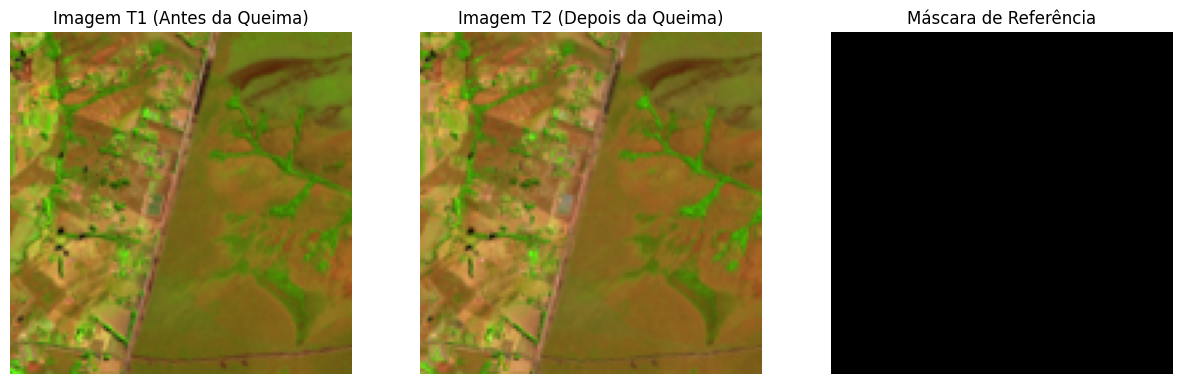

In [4]:
# Pega um lote de dados do nosso loader
t1_batch, t2_batch, mask_batch = next(iter(data_loader))

# Seleciona a primeira amostra do lote para visualização
t1_sample = t1_batch[0]
t2_sample = t2_batch[0]
mask_sample = mask_batch[0]

print("Dimensões do tensor T1 (Bandas, Altura, Largura):", t1_sample.shape)
print("Dimensões do tensor T2 (Bandas, Altura, Largura):", t2_sample.shape)
print("Dimensões da Máscara (Canais, Altura, Largura):", mask_sample.shape)

# As bandas são: 1-Vermelho, 2-NIR, 3-SWIR1, 4-SWIR2
# Vamos criar uma composição colorida falsa (SWIR1, NIR, RED) para melhor visualização da vegetação
# Índices no tensor: 0-RED, 1-NIR, 2-SWIR1, 3-SWIR2
t1_rgb = t1_sample[[2, 1, 0], :, :].permute(1, 2, 0)
t2_rgb = t2_sample[[2, 1, 0], :, :].permute(1, 2, 0)

# Plota as imagens e a máscara lado a lado
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
axs[0].imshow(t1_rgb)
axs[0].set_title("Imagem T1 (Antes da Queima)")
axs[0].axis('off')

axs[1].imshow(t2_rgb)
axs[1].set_title("Imagem T2 (Depois da Queima)")
axs[1].axis('off')

axs[2].imshow(mask_sample.squeeze(), cmap='gray')
axs[2].set_title("Máscara de Referência")
axs[2].axis('off')

plt.show()